# WRF perturbations

In [1]:
%cd ~/git/wrf_lrf_les/

/home/561/tr2908/git/wrf_lrf_les


In [2]:
import sys

sys.path.append("analysis/")

import datetime
import matplotlib.pyplot as plt
import modules.wrf_perturbation as wp
import numpy as np
from dask.distributed import Client

print("Report last updated at " + str(datetime.datetime.now()) + " UTC.")

Start a dask cluster for parallel processing.

In [ ]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 7
Total threads: 28,Total memory: 125.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33901,Workers: 7
Dashboard: http://127.0.0.1:8787/status,Total threads: 28
Started: Just now,Total memory: 125.18 GiB
Comm: tcp://127.0.0.1:40271,Total threads: 4
Dashboard: http://127.0.0.1:38245/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:33783,


## Settings

In [ ]:
# Directories for results to read.
dirs = {"1 km": "1km", "4 km": "4km", "100 m": "LES"}

# The point at which the RCE run ends and control + perturbation runs begin.
runs_start = {
    "4 km": "2000-03-01",
    "1 km": "2000-03-01",
    "1 km np": "2000-03-01",
    "100 m": "2000-04-25",
}

# Start and end times for designated RCE periods.
RCE_times = {
    "4 km": ["2000-04-01", "2000-06-01"],
    "1 km": ["2000-04-01", "2000-06-01"],
    "1 km np": ["2000-04-01", "2000-06-01"],
    "100 m": ["2000-05-04", "2000-05-07"],
}

# Perturbation details.
perts = {
    "res": list(dirs.keys()),  # Dataset names.
    "dir": [dirs[x] for x in dirs.keys()],  # Dataset directories.
    "levels": ["850", "730", "600", "500", "412"],  # Perturbed levels in hPa.
    "T": ["0.5", "-0.5"],  # Temperature perturbations in K day-1.
    "q": ["0.0002", "-0.0002"], # Specific humidity perturbations in kg kg-1 day-1.
}  

# Input directories with dataset names as keys.
basedir = "/g/data/up6/tr2908/em_quarter_ss/v4.1.4/output/"
inputs = wp.input_map(perts=perts, basedir=basedir)

# Figure settings.
plt.rcParams["figure.figsize"] = wp.FIGURE_SIZE  # Figure size for non-facetted plots.
plt.rcParams["font.size"] = 14  # Font size for plots.
plt.rcParams["axes.formatter.useoffset"] = False  # Don't use offsets in plots.

plot_levels = [850, 500, 410, 100]  # Pressure levels to plot individually [hPa].

## Read data

The script `~/code/sh/extract_WRF_variables_parallel.sh` runs, in parallel, a python script that extracts variables of interest from WRF `wrfout` files, optionally interpolates the 3D variables to vertical pressure levels, and takes spatial means across horizontal dimensions. These profiles of mean values per time are written to `wrfvar` files, which are then opened here. Note results are cached in `data/WRF`.

In [ ]:
wrf_pw_ts, wrf_profs, wrf_pw_sv_ts, wrf_responses, wrf_responses_std = wp.load_cache_data(
    inputs=inputs, dirs=dirs, runs_start=runs_start, RCE_times=RCE_times
)

Reading 100 m dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/output/LES/RCE/): RCE...
Reading 100 m dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/output/LES/control/): Control...
Reading 100 m dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/output/LES/pert_850hPa_T_0.5K/): T 0.5 @850...
Reading 100 m dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/output/LES/pert_850hPa_T_-0.5K/): T -0.5 @850...
Reading 100 m dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/output/LES/pert_850hPa_q_0.0002kgkg-1/): q 0.0002 @850...
Reading 100 m dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/output/LES/pert_850hPa_q_-0.0002kgkg-1/): q -0.0002 @850...
Reading 100 m dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/output/LES/pert_412hPa_T_0.5K/): T 0.5 @412...
Reading 100 m dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/output/LES/pert_412hPa_T_-0.5K/): T -0.5 @412...
Reading 100 m dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/output/LES/pert_412hPa_q_0.0002kgkg-1/): q 0.0002 @412...
Reading

Read MONC data:

In [ ]:
monc_cwv = wp.MONC_CWV_data()
monc_responses = wp.MONC_response_data()

Collect responses into one DataFrame:

In [ ]:
all_responses = wp.concat_diffs(responses=[wrf_responses, monc_responses])

Read reference data from Kuang et al.

In [ ]:
ref_responses = wp.kuang_data(ref_dir="/g/data/up6/tr2908/LRF_SCM_results/")

## Radiative-convective equilibrium (RCE)

To determine when the simulations have reached RCE, we look for stabilisation of the precipitable water (PW) field. Here is spatially-averaged PW by time for each simulation in WRF. The green highlighted region is the time span over which average profiles are calculated for all runs. MONC is also included here.

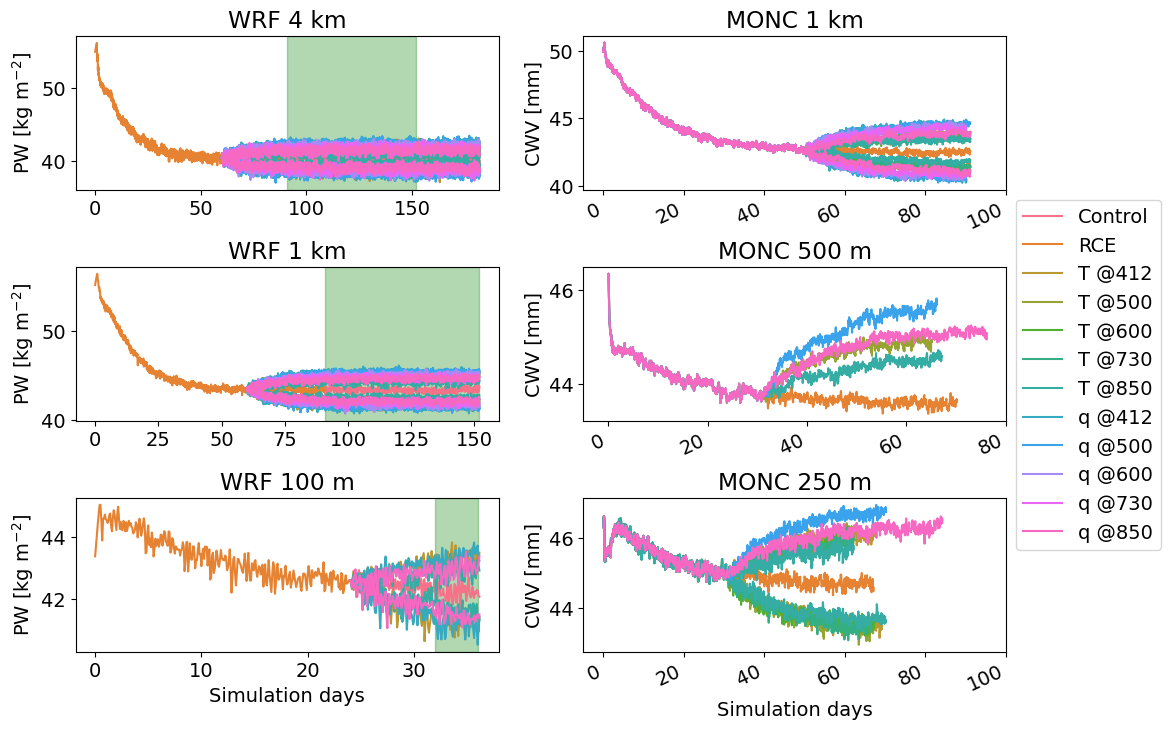

In [ ]:
wp.plot_ts_wrf_monc(
    wrf_pw_ts=wrf_pw_ts,
    monc_cwv=monc_cwv,
    WRF_RCE_times=RCE_times,
    file='paper/figures/runs_timeseries.pdf',
)

## Mean profiles over RCE period

In [ ]:
ctrl_profs = wp.mean_control_profiles(wrf_profs=wrf_profs)
wp.plot_mean_profiles(profs=ctrl_profs, file='paper/figures/rce_profiles.pdf', figsize=(12, 9), retick={'va': [0, 0.03]})

## Convective organisation

Examine the spatial variance of precipitable water scaled by its spatial mean (not shown in paper) to see whether there is any evidence of convective organisation.

In [ ]:
_, axs = plt.subplots(figsize=(12,10), nrows=len(wrf_pw_sv_ts), gridspec_kw={'hspace': 0.3})
for i, res in enumerate(wrf_pw_sv_ts):
    wrf_pw_sv_ts[res].pw_scaled_var.plot(x='time', hue='Dataset', ax=axs[i])
    axs[i].legend([])
    axs[i].set_xlabel('')
    axs[i].set_ylabel('var/mean of pw')

## Differences in averaged RCE profiles

Differences here are defined as `perturbed - control`. The red vertical line shows zero difference.

In [ ]:
wp.plot_responses(responses=all_responses, refs=ref_responses, show_negs=True)

In [ ]:
wrf_stds = wrf_responses_std[wrf_responses_std.res == '100 m'].copy()
hydromet_vars=['q', 'qcloud', 'qice', 'qsnow', 'qrain', 'qgraup']
for v in hydromet_vars:
      wrf_stds[v] = wrf_stds[v] * 1000

wrf_resps = all_responses[
    np.logical_and(all_responses.Resolution == '100 m', all_responses.Model == 'WRF')
].dropna()

wp.plot_responses_with_std(resp=wrf_resps, std=wrf_stds)

### TODO:

- Check which turbulence closure scheme was used. Rerun 1km runs with different turbulence scheme to see differences?
- Try to figure out why the domain is drying out at about 850 hPa. 